In [13]:
import torch
import math


class LipschitzLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.empty((out_features, in_features), requires_grad=True))
        self.bias = torch.nn.Parameter(torch.empty((out_features), requires_grad=True))
        self.c = torch.nn.Parameter(torch.empty((1), requires_grad=True))
        self.softplus = torch.nn.Softplus()
        self.initialize_parameters()

    def initialize_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

        # compute lipschitz constant of initial weight to initialize self.c
        W = self.weight.data
        W_abs_row_sum = torch.abs(W).sum(1)
        self.c.data = W_abs_row_sum.max()  # just a rough initialization

    def get_lipschitz_constant(self):
        return self.softplus(self.c)

    def forward(self, input):
        lipc = self.softplus(self.c)
        scale = lipc / torch.abs(self.weight).sum(1)
        scale = torch.clamp(scale, max=1.0)
        return torch.nn.functional.linear(input, self.weight * scale.unsqueeze(1), self.bias)


class lipmlp(torch.nn.Module):
    def __init__(self, dims):
        """
        dim[0]: input dim
        dim[1:-1]: hidden dims
        dim[-1]: out dim

        assume len(dims) >= 3
        """
        super().__init__()

        self.layers = torch.nn.ModuleList()
        for ii in range(len(dims) - 2):
            self.layers.append(LipschitzLinear(dims[ii], dims[ii + 1]))

        self.layer_output = LipschitzLinear(dims[-2], dims[-1])
        self.relu = torch.nn.ReLU()

    def get_lipschitz_loss(self):
        loss_lipc = 1.0
        for ii in range(len(self.layers)):
            loss_lipc = loss_lipc * self.layers[ii].get_lipschitz_constant()
        loss_lipc = loss_lipc * self.layer_output.get_lipschitz_constant()
        return loss_lipc

    def forward(self, x):
        for ii in range(len(self.layers)):
            x = self.layers[ii](x)
            x = self.relu(x)
        return self.layer_output(x)


# Example forward pass
model = lipmlp([10, 20, 30, 40])
x = torch.randn(10, 10)
y = model(x)
print(y.shape)

# Example loss computation
# compute loss
# loss_sdf = loss_func(sdf0, gt0) + loss_func(sdf1, gt1) 
# loss_lipschitz = lam * model.get_lipschitz_loss()
# loss = loss_sdf + loss_lipschitz

torch.Size([10, 40])


INFO-VAE

In [14]:
import argparse
from argparse import Namespace

import lightning as L
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

import wandb
from utility import Utility
from torch import optim
from datasettype import DatasetType
from callbacks import CustomCallbacks
import sys


def parse_args():
    if 'ipykernel' not in sys.modules:
        parser = argparse.ArgumentParser(description='Train an autoencoder')
        parser.add_argument('--z', type=int, default=32, help='Latent dimension size')
        parser.add_argument('--dataset', type=int, default=1, help='Database to use')
        parser.add_argument('--epochs', type=int, default=10, help='Number of epochs to train')
        parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
        parser.add_argument('--num_workers', type=int, default=1, help='Number of workers for dataloader')
        parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate')
        parser.add_argument('--limit_train_batches', type=float, default=1.0,
                            help='Fraction of training data to use per epoch')
        parser.add_argument('--loss', type=str, default="mse_mdd_lipschitz",
                            help='Loss function to use: mse_mdd or mse_mmd_lipschitz')
        return parser.parse_args()
    else:
        return Namespace(z=32, dataset=1, epochs=100, batch_size=32, num_workers=8, lr=1e-3, limit_train_batches=0.1,
                         loss="mse_mmd")


class MSE_MMD(torch.nn.Module):
    def __init__(self, beta, z_dim):
        super().__init__()
        self.beta = beta
        self.z_dim = z_dim

    def forward(self, input, target, z):
        if self.beta == 0:
            return torch.mean((input - target) ** 2)
        else:
            true_samples = torch.randn((200, self.z_dim), requires_grad=False, device=input.device)
            mmd = self.beta * compute_mmd(true_samples, z)
            return torch.mean((input - target) ** 2) + mmd


class MSE_MMD_Lipschitz(torch.nn.Module):
    def __init__(self, beta, z_dim, lamb, encoder):
        super().__init__()
        self.MSE_MMD = MSE_MMD(beta, z_dim)
        self.model = encoder
        self.lamb = lamb

    def forward(self, input, target, z):
        loss = self.MSE_MMD(input, target, z)
        loss_lipc = self.model.get_lipschitz_loss()

        # MSE + beta*MMD + lamb*Lipschitz regularizer
        return loss + self.lamb * loss_lipc



In [15]:
# class Encoder(torch.nn.Module):
#     def __init__(self, img_size: tuple, latent_dim: int = 10):
#         channels, height, width = img_size
#         z_dim = latent_dim
# 
#         super(Encoder, self).__init__()
#         self.model = torch.nn.ModuleList([
#             torch.nn.Conv2d(channels, 64, 4, 2, padding=1),
#             torch.nn.LeakyReLU(),
#             torch.nn.Conv2d(64, 128, 4, 2, padding=1),
#             torch.nn.LeakyReLU(),
#             torch.nn.Flatten(),
#             torch.nn.Linear(128 * (height // 4) * (height // 4), 1024),  # if h=64 -> 32768
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(1024, z_dim)
#         ])

class Encoder(torch.nn.Module):
    def __init__(self, img_size: tuple, latent_dim: int = 10):
        channels, height, width = img_size
        z_dim = latent_dim

        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(channels, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(128 * (height // 4) * (height // 4), 1024),  # if h=64 -> 32768
            torch.nn.LeakyReLU(),
            LipschitzLinear(1024, z_dim)  # Apply Lipschitz regularizer to the bottleneck layer
        ])

    def get_lipschitz_loss(self):
        return self.model[-1].get_lipschitz_constant()

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x


class Decoder(torch.nn.Module):
    def __init__(self, img_size: tuple, latent_dim: int = 10):
        channels, height, width = img_size
        z_dim = latent_dim

        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128 * (height // 4) * (height // 4)),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128, height // 4, height // 4)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, channels, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x


def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)  # (x_size, 1, dim)
    y = y.unsqueeze(0)  # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / torch.tensor(dim, dtype=torch.float32)

    return torch.exp(-kernel_input)  # (x_size, y_size)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
    return mmd



In [16]:
class AutoEncoder(L.LightningModule):
    def __init__(self, encoder: Encoder, decoder: Decoder, z_dim: int, lr: float, loss_func: str,
                 beta: float = 1.0, lamb=0.01):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        if loss_func == "mse_mmd":
            self.loss_func = MSE_MMD(beta, z_dim)
        elif loss_func == "mse_mmd_lipschitz":
            self.loss_func = MSE_MMD_Lipschitz(beta, z_dim, lamb, encoder)
        else:
            raise ValueError("Invalid loss function")
        self.lr = lr
        self.test_losses = []

    def training_step(self, batch, batch_idx):
        x, y = batch  # x.shape: (200, 1, 64, 64), y.shape: (200, 1, 6)
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)

        loss = self.loss_func(x_reconstructed, x, z)

        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        loss = self.loss_func(x_reconstructed, x, z)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        loss = self.loss_func(x_reconstructed, x, z)
        self.test_losses.append(loss)
        return {"test_loss": loss}

    def on_test_epoch_end(self):
        avg_loss = torch.stack(self.test_losses).mean()
        self.log("avg_test_loss", avg_loss)
        self.test_losses = []  # reset for the next epoch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | encoder   | Encoder | 6.6 M 
1 | decoder   | Decoder | 6.6 M 
2 | loss_func | MSE_MMD | 0     
--------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.734    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 150: 'val_loss' reached 0.03252 (best 0.03252), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=0-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 300: 'val_loss' reached 0.02195 (best 0.02195), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=1-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 450: 'val_loss' reached 0.01694 (best 0.01694), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=2-step=450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 600: 'val_loss' reached 0.01427 (best 0.01427), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=3-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 750: 'val_loss' reached 0.01247 (best 0.01247), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=4-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 900: 'val_loss' reached 0.01140 (best 0.01140), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=5-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1050: 'val_loss' reached 0.01037 (best 0.01037), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=6-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1200: 'val_loss' reached 0.01020 (best 0.01020), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=7-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1350: 'val_loss' reached 0.00930 (best 0.00930), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=8-step=1350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1500: 'val_loss' reached 0.00895 (best 0.00895), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=9-step=1500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1650: 'val_loss' reached 0.00857 (best 0.00857), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=10-step=1650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1800: 'val_loss' reached 0.00828 (best 0.00828), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=11-step=1800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1950: 'val_loss' reached 0.00818 (best 0.00818), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=12-step=1950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 2100: 'val_loss' reached 0.00789 (best 0.00789), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=13-step=2100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2250: 'val_loss' reached 0.00774 (best 0.00774), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=14-step=2250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2400: 'val_loss' reached 0.00761 (best 0.00761), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=15-step=2400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2550: 'val_loss' reached 0.00744 (best 0.00744), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=16-step=2550.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2700: 'val_loss' reached 0.00728 (best 0.00728), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=17-step=2700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2850: 'val_loss' reached 0.00717 (best 0.00717), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=18-step=2850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 3000: 'val_loss' reached 0.00703 (best 0.00703), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=19-step=3000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 3150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3300: 'val_loss' reached 0.00689 (best 0.00689), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=21-step=3300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3450: 'val_loss' reached 0.00688 (best 0.00688), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=22-step=3450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3600: 'val_loss' reached 0.00669 (best 0.00669), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=23-step=3600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3750: 'val_loss' reached 0.00662 (best 0.00662), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=24-step=3750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3900: 'val_loss' reached 0.00639 (best 0.00639), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=25-step=3900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 4050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 4200: 'val_loss' reached 0.00633 (best 0.00633), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=27-step=4200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4650: 'val_loss' reached 0.00618 (best 0.00618), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=30-step=4650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4950: 'val_loss' reached 0.00612 (best 0.00612), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=32-step=4950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 5100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 5250: 'val_loss' reached 0.00604 (best 0.00604), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=34-step=5250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 5400: 'val_loss' reached 0.00586 (best 0.00586), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=35-step=5400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 5550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 5700: 'val_loss' reached 0.00585 (best 0.00585), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=37-step=5700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 5850: 'val_loss' reached 0.00576 (best 0.00576), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=38-step=5850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 6000: 'val_loss' reached 0.00576 (best 0.00576), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=39-step=6000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 6150: 'val_loss' reached 0.00574 (best 0.00574), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=40-step=6150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 6300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 6450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 6600: 'val_loss' reached 0.00567 (best 0.00567), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=43-step=6600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 6750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 6900: 'val_loss' reached 0.00561 (best 0.00561), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=45-step=6900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 7050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 7200: 'val_loss' reached 0.00557 (best 0.00557), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=47-step=7200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 7350: 'val_loss' reached 0.00553 (best 0.00553), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=48-step=7350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 7500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 7650: 'val_loss' reached 0.00542 (best 0.00542), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=50-step=7650.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 7800: 'val_loss' reached 0.00541 (best 0.00541), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=51-step=7800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 7950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 8100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 8250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 8400: 'val_loss' reached 0.00538 (best 0.00538), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=55-step=8400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 8550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 8700: 'val_loss' reached 0.00530 (best 0.00530), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=57-step=8700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 8850: 'val_loss' reached 0.00525 (best 0.00525), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=58-step=8850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 9000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 9150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 9300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 9450: 'val_loss' reached 0.00523 (best 0.00523), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=62-step=9450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 9600: 'val_loss' reached 0.00518 (best 0.00518), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=63-step=9600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64, global step 9750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 9900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 10050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 10200: 'val_loss' reached 0.00515 (best 0.00515), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=67-step=10200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 10350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 10500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 10650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71, global step 10800: 'val_loss' reached 0.00512 (best 0.00512), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=71-step=10800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 10950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 11100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 11250: 'val_loss' reached 0.00505 (best 0.00505), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=74-step=11250.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 11400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 11550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 11700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 11850: 'val_loss' reached 0.00504 (best 0.00504), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=78-step=11850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 12000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 12150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 12300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 12450: 'val_loss' reached 0.00504 (best 0.00504), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=82-step=12450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 12600: 'val_loss' reached 0.00495 (best 0.00495), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=83-step=12600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 12750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 12900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 13050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 13200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 13350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 13500: 'val_loss' reached 0.00493 (best 0.00493), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=89-step=13500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 13650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 13800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 13950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 14100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 14250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 14400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 14550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97, global step 14700: 'val_loss' reached 0.00488 (best 0.00488), saving model to 'C:\\GitHub\\Research-Experiments\\autoencoder\\wandb\\run-20240523_115104-4n6dwinj\\files\\checkpoints\\epoch=97-step=14700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 14850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 15000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_loss       │   0.005077153444290161    │
└───────────────────────────┴───────────────────────────┘

avg_test_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_test_loss,0.00508
epoch,100
train_loss,0.00421
trainer/global_step,15000
val_loss,0.00491


Run name: run-20240523_115104-4n6dwinj


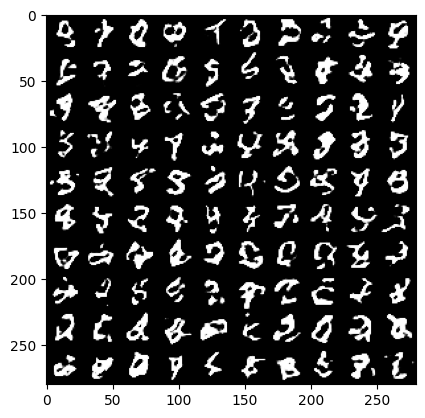

In [17]:
def train():
    args = parse_args()
    z_dim = args.z
    dataset = DatasetType(args.dataset)
    epochs = args.epochs
    batch_size = args.batch_size
    num_workers = args.num_workers
    lr = args.lr
    limit_train_batches = args.limit_train_batches
    loss = args.loss

    torch.set_float32_matmul_precision('medium')

    data, im_shape, project_name = Utility.setup(dataset, batch_size, num_workers)

    wandb.init(project="info-vae", entity="oboii", config=args,
               tags=[f"l={loss}, z={z_dim}", f"lr={lr}", f"batch_size={batch_size}"],
               name=f"l={loss}_z={z_dim}_lr={lr}_batch_size={batch_size}_{wandb.util.generate_id()}")

    wandb_logger = WandbLogger()

    checkpoint_dir = f"{wandb.run.dir}/checkpoints"
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min', save_last=True)

    encoder = Encoder(latent_dim=z_dim, img_size=im_shape)
    decoder = Decoder(latent_dim=z_dim, img_size=im_shape)

    autoencoder = AutoEncoder(encoder, decoder, z_dim, lr, loss)

    # Train the model
    trainer = L.Trainer(limit_train_batches=limit_train_batches, max_epochs=epochs,
                        accelerator="gpu", devices="1", logger=wandb_logger,
                        callbacks=[
                            CustomCallbacks(plot_ever_n_epoch=4, z_dim=z_dim, wandb_logger=wandb_logger,
                                            dataset=dataset),
                            checkpoint_callback])
    trainer.fit(model=autoencoder, datamodule=data)
    trainer.test(model=autoencoder, datamodule=data)

    # second to last element is the run name
    # if windows:
    if "\\" in wandb.run.dir:
        run_name = wandb.run.dir.split("\\")[-2]
    else:  # if linux
        run_name = wandb.run.dir.split("/")[-2]

    wandb.finish()

    print(f"Run name: {run_name}")
    return run_name


run_name = train()

In [18]:
def eval(run_name: str):
    print("Evaluating the model")

    args = parse_args()
    z_dim = args.z
    dataset = DatasetType(args.dataset)
    lr = args.lr
    epochs = args.epochs
    limit_train_batches = args.limit_train_batches
    batch_size = 200  # override the batch size
    loss = args.loss

    data_module, im_shape, project_name = Utility.setup(dataset, batch_size, num_workers=1)

    encoder = Encoder(latent_dim=z_dim, img_size=im_shape)
    decoder = Decoder(latent_dim=z_dim, img_size=im_shape)

    if run_name == "":
        run_name = Utility.get_latest_version()
        print(f"No run name provided. Using the latest version. Run name: {run_name}")

    logs_dir = f"./wandb/{run_name}/files"
    checkpoint = f"{logs_dir}/checkpoints/last.ckpt"
    autoencoder = AutoEncoder.load_from_checkpoint(
        checkpoint, encoder=encoder, decoder=decoder, z_dim=z_dim, lr=lr, loss_func=loss)

    # Choose your trained nn.Module
    encoder = autoencoder.encoder
    encoder.eval()

    data_module.prepare_data()
    data_module.setup("test")
    for x, y in data_module.test_dataloader():
        x = x.to(autoencoder.device)
        x = x[:100]  # dimension: (100, 1, 64, 64)
        # save in the checkpoint directory
        Utility.display_images(x, path=f"{logs_dir}/eval_original_images.png")
        z = encoder(x)
        Utility.display_embeddings(decoder, z, path=f"{logs_dir}/eval_im_enc_decode.png")
        break

    data_module.teardown("test")

    # gen_z = torch.randn((100, z_dim), requires_grad=False, device=autoencoder.device)
    # display_embeddings(gen_z)

    print("Evaluation done")


eval(run_name)


Evaluating the model
Evaluation done
